In [92]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams.update({'font.size': 22})

In [93]:
def convert_raw(data_series):
    """Replace strings with numerical equivalent and 
    cast datqa to numerical values."""
    replace_map = {
        ",": ".",
        "p": "e-12",
        "n": "e-9",
        "m": "e-6"
    }
    for key, value in replace_map.items():
        data_series = data_series.str.replace(key, value)
    return pd.to_numeric(data_series)

In [94]:
def load_data(file_path, raw=False):
    """Loads data from file and converts time from s to ns.
    
    Unit coversion is needed to prevent ZeroDevionErros 
    automatically prevented by lmfit, which in turn 
    restricts the minimum sigma value being used.
    Ref:
    https://github.com/lmfit/lmfit-py/blob/21d3e6b008a74a4aaa9e97eae32f76a316f18671/lmfit/lineshapes.py#L52
    """
    data = pd.read_csv(file_path, 
            skiprows=2, header=None, sep="\s+",
            names=["tau_HBT", "g2_HBT", "tau_none_fit","g2_none_fit"]
           )
    if raw:
        data["tau_HBT"] = convert_raw(data["tau_HBT"])
        data["g2_HBT"] = convert_raw(data["g2_HBT"])
    data= data[["tau_HBT", "g2_HBT"]]
    data["tau_HBT"] *=1e9
    return data.set_index("tau_HBT")
    

In [95]:
load_data("0911 Messung7/0.0 nm/0 G2 12k ec - HBTconversion.txt")

,g2_HBT
tau_HBT,
-50.3542,1.007040
-50.1923,0.839203
-50.0304,0.615415
-49.8684,1.062990
-49.7065,1.062990
...,...
49.3827,1.286780
49.5446,1.118940
49.7065,1.007040


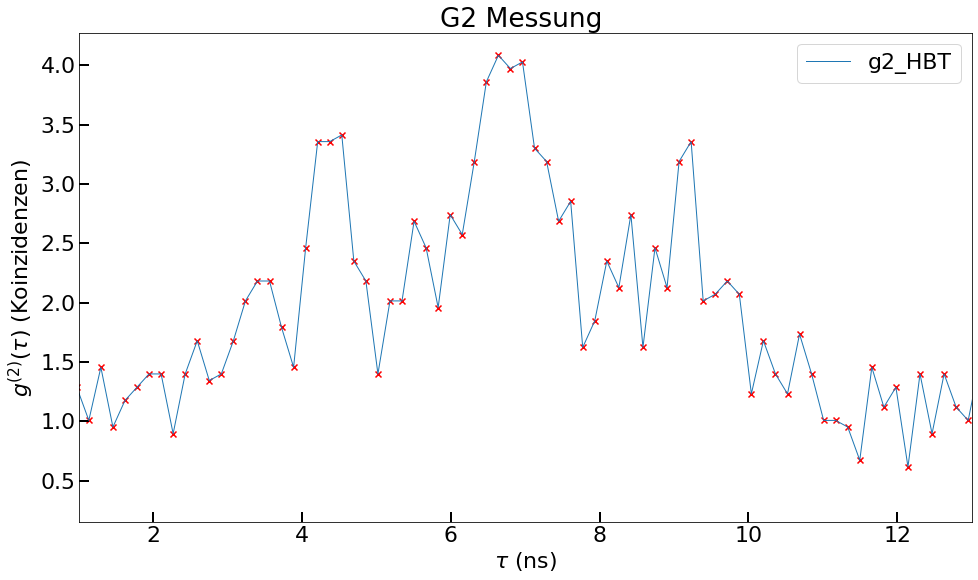

In [96]:
g2_0 = load_data("0911 Messung7/0.0 nm/0 G2 12k ec - HBTconversion.txt")

Werte = pd.Series(g2_0["g2_HBT"]).values
yerrors = np.sqrt(Werte)

ax = g2_0.plot(title = "G2 Messung ", linewidth=1)
plt.scatter(g2_0.index, g2_0, marker='x', color = 'red')
ax.tick_params(direction="in", length=10, width=2)
ax.set_xlim([1.0, 13.0])
ax.set_xlabel('$\\tau$ (ns)') 
ax.set_ylabel('$g^{(2)}(\\tau)$ (Koinzidenzen)')
plt.savefig("G2_Rausch.png")

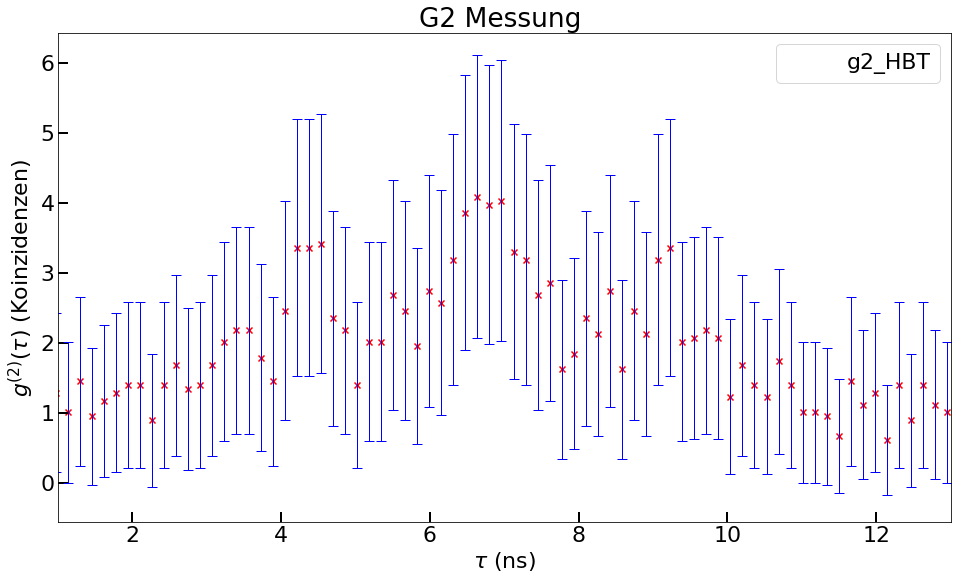

In [97]:
ax = g2_0.plot(title = "G2 Messung ", yerr=yerrors, capsize=5, color='black', linewidth=1, ecolor = 'Blue',ls='none')
plt.scatter(g2_0.index, g2_0, marker='x', color = 'red')
ax.tick_params(direction="in", length=10, width=2)
ax.set_xlim([1.0, 13.0])
ax.set_xlabel('$\\tau$ (ns)') 
ax.set_ylabel('$g^{(2)}(\\tau)$ (Koinzidenzen)')
plt.savefig("G2_Fehler.png")

## Spektrum glätten

In [98]:
def smooth_data(data_series, kernel_size=5):
    """Smoth data by averaging a triangle weigted kernal of size 'kernel_size'."""
    return data_series.rolling(kernel_size, center=True, win_type="triang").mean().dropna()


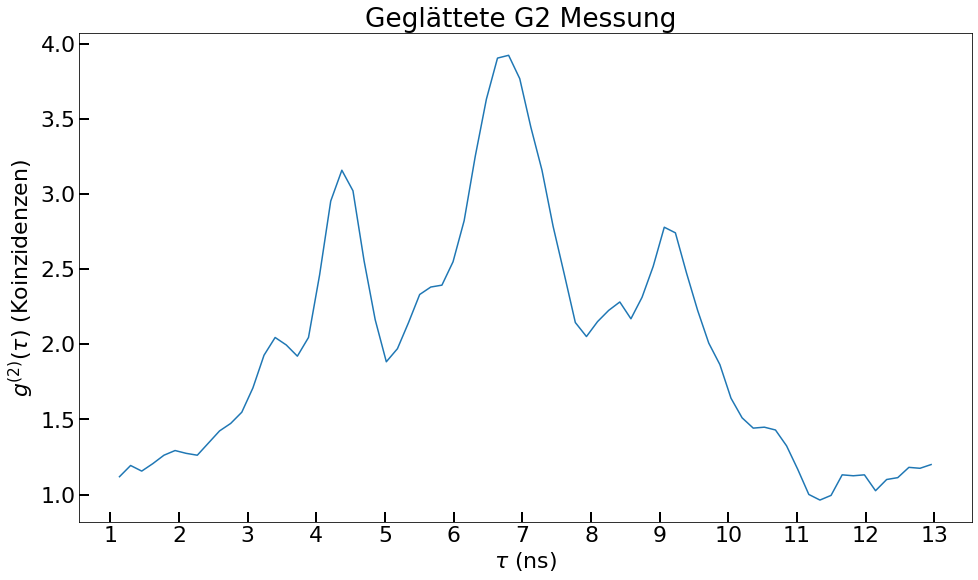

In [99]:
g2_0_smooth = smooth_data(g2_0["g2_HBT"])
ax = g2_0_smooth[1:13].plot(title = "Geglättete G2 Messung ")
ax.tick_params(direction="in", length=10, width=2)
loc = plticker.MultipleLocator(base=1.0)
ax.xaxis.set_major_locator(loc)
ax.set_xlabel('$\\tau$ (ns)') 
ax.set_ylabel('$g^{(2)}(\\tau)$ (Koinzidenzen)')
plt.savefig("G2_Geglättet.png")

## Falls lmfit nicht installier ist
```console
!pip install lmfit
```

In [100]:
from lmfit.models import GaussianModel, ConstantModel

In [101]:
def get_max_val_index(series):
    """Get index of max value.
    
    Note:
    If Max value isn't unique you might get the wrong index.
    """
    subset = series[series == series.max()]
    return subset.index.values[0]


In [102]:
def load_data(file_path, raw=False):
    """Loads data from file and converts time from s to ns.
    
    Unit coversion is needed to prevent ZeroDevionErros 
    automatically prevented by lmfit, which in turn 
    restricts the minimum sigma value being used.
    Ref:
    https://github.com/lmfit/lmfit-py/blob/21d3e6b008a74a4aaa9e97eae32f76a316f18671/lmfit/lineshapes.py#L52
    """
    data = pd.read_csv(file_path, 
            skiprows=2, header=None, sep="\s+",
            names=["tau_HBT", "g2_HBT", "tau_none_fit","g2_none_fit"]
           )
    if raw:
        data["tau_HBT"] = convert_raw(data["tau_HBT"])
        data["g2_HBT"] = convert_raw(data["g2_HBT"])
    data= data[["tau_HBT", "g2_HBT"]]
    data["tau_HBT"] *=1e9
    return data.set_index("tau_HBT")

# Fitfunktion für die Peaks der G2 Messung


In [103]:
def fit_3_peaks(data_series, center=6.6, FWHM=0.5,delta_center=2.5):
    """Fit data with 3 gaussion peaks and a constant offset.
    """
    gauss_FWHM_correction = 2.3548200
    sigma = FWHM/gauss_FWHM_correction

    amplitude_correction = (sigma*np.sqrt(2*np.pi))

    amplitude = (data_series.max()-1) * amplitude_correction

    model_3_gauss = (
        ConstantModel() + 
        GaussianModel(prefix="ls_") + 
        GaussianModel(prefix="ll_ss_") + 
        GaussianModel(prefix="sl_")
    )
    params = model_3_gauss.make_params(
        c=1,
        ls_amplitude=amplitude/2 ,
        ls_center=center-delta_center,
        ls_sigma=sigma,
        ll_ss_amplitude=amplitude ,
        ll_ss_center=center,
        ll_ss_sigma=sigma,
        sl_amplitude=amplitude/2 ,
        sl_center=center+delta_center,
        sl_sigma=sigma,
    )
    y = data_series.dropna().values
    x = data_series.dropna().index.values
    fit = model_3_gauss.fit(y, params=params, x=x)
    return fit
fit = fit_3_peaks(g2_0["g2_HBT"])
x = np.arange(1,13,0.1)
Fehler = (fit.params['ls_amplitude'].stderr / fit.params['ls_amplitude'].value + 
          fit.params['ls_center'].stderr / fit.params['ls_center'].value + 
          fit.params['ls_sigma'].stderr / fit.params['ls_sigma'].stderr)
    

# Maximal und Minimalfehler definiert um einen Sigma-Schlauch zu plooten, der kontinuierlich den Verlauf der Fehlergrenzen darstellt

In [104]:
ls_A_up =  fit.params['ls_amplitude'].value   + fit.params['ls_amplitude'].stderr 
ls_center_up =  fit.params['ls_center'].value  + fit.params['ls_center'].stderr 
ls_sigma_up =  fit.params['ls_sigma'].value  + fit.params['ls_sigma'].stderr 


sl_A_up =  fit.params['sl_amplitude'].value + fit.params['sl_amplitude'].stderr 
sl_center_up =  fit.params['sl_center'].value + fit.params['sl_center'].stderr 
sl_sigma_up =  fit.params['sl_sigma'].value  + fit.params['sl_sigma'].stderr 

ll_ss_A_up =  fit.params['ll_ss_amplitude'].value  + fit.params['ll_ss_amplitude'].stderr 
ll_ss_center_up =  fit.params['ll_ss_center'].value  + fit.params['ll_ss_center'].stderr
ll_ss_sigma_up =  fit.params['ll_ss_sigma'].value  + fit.params['ll_ss_sigma'].stderr 
c_up =  fit.params['c'].value + (1 + fit.params['c'].stderr / fit.params['c'].value)

Schlauch_up = (ls_A_up / np.sqrt( ls_sigma_up**2 * 2 * np.pi) * np.exp(-(x - ls_center_up )**2 / (2 * ls_sigma_up**2)) + 
               sl_A_up / np.sqrt( sl_sigma_up**2 * 2 * np.pi) * np.exp(-(x - sl_center_up )**2 / (2 * sl_sigma_up**2))+
              ll_ss_A_up / np.sqrt( ll_ss_sigma_up**2 * 2 * np.pi) * np.exp(-(x - ll_ss_center_up )**2 / (2 * ll_ss_sigma_up**2))+ c_up -0.5
               )


ls_A_down =  fit.params['ls_amplitude'].value - fit.params['ls_amplitude'].stderr
ls_center_down =  fit.params['ls_center'].value - fit.params['ls_center'].stderr
ls_sigma_down =  fit.params['ls_sigma'].value - fit.params['ls_sigma'].stderr

sl_A_down =  fit.params['sl_amplitude'].value - fit.params['sl_amplitude'].stderr
sl_center_down =  fit.params['sl_center'].value - fit.params['sl_center'].stderr
sl_sigma_down =  fit.params['sl_sigma'].value - fit.params['sl_sigma'].stderr

ll_ss_A_down =  fit.params['ll_ss_amplitude'].value - fit.params['ll_ss_amplitude'].stderr
ll_ss_center_down =  fit.params['ll_ss_center'].value - fit.params['ll_ss_center'].stderr
ll_ss_sigma_down =  fit.params['ll_ss_sigma'].value - fit.params['ll_ss_sigma'].stderr
c_down =  fit.params['c'].value - fit.params['c'].stderr

Schlauch_down = (ls_A_down / np.sqrt( ls_sigma_down**2 * 2 * np.pi) * np.exp(-(x - ls_center_down )**2 / (2 * ls_sigma_down**2)) + 
                sl_A_down / np.sqrt( sl_sigma_down**2 * 2 * np.pi) * np.exp(-(x - sl_center_down )**2 / (2 * sl_sigma_down**2)) + 
                 ll_ss_A_down / np.sqrt( ll_ss_sigma_down**2 * 2 * np.pi) * np.exp(-(x - ll_ss_center_down )**2 / (2 * ll_ss_sigma_down**2)) + c_down-0.5)


# Plot der Fits und des Sigmaschlauchs

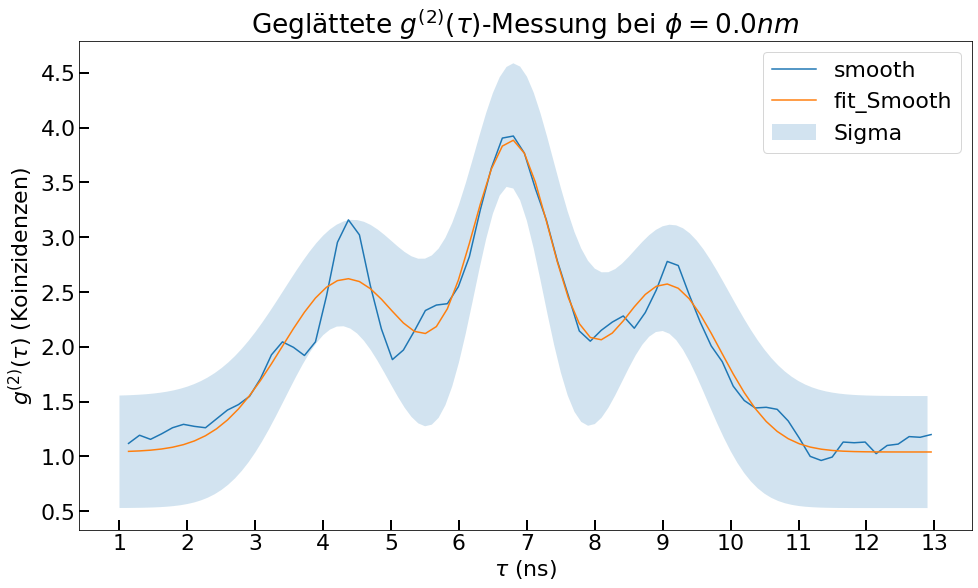

In [105]:
g2_0["fit"] = pd.Series(fit.best_fit, index=g2_0["g2_HBT"].index)
g2_0["smooth"] = smooth_data(g2_0["g2_HBT"])
fit_smooth = fit_3_peaks(g2_0["smooth"])
g2_0["fit_smooth"] = pd.Series(fit_smooth.best_fit, index=g2_0["smooth"].dropna().index)
#g2_0[2:12][["g2_HBT","fit","smooth","fit_smooth"]].plot()
ax = g2_0[1:13][["smooth","fit_smooth"]].plot(title = "Geglättete $g^{(2)}(\\tau)$-Messung bei $\phi=0.0nm$")
#ax = g2_0["smooth", "fit_smooth"][1:13].plot(title = "Verrauschte G2 Messung ")
#plt.plot(x, Schlauch_up)
#plt.plot(x, Schlauch_down)
ax.fill_between(x, Schlauch_down, Schlauch_up, alpha=0.2)
ax.tick_params(direction="in", length=10, width=2)
loc = plticker.MultipleLocator(base=1)
ax.xaxis.set_major_locator(loc)
ax.set_xlabel('$\\tau$ (ns)') 
ax.legend( ("smooth", "fit_Smooth", "Sigma"))
ax.set_ylabel('$g^{(2)}(\\tau)$ (Koinzidenzen)')
plt.savefig("G2_Phase0.png")

Plotselection geht irgendwie nicht

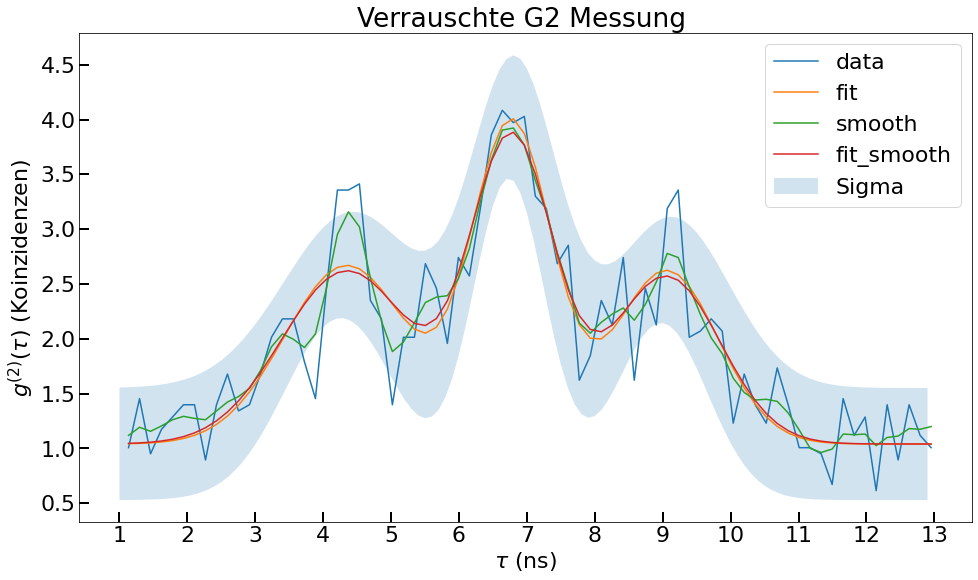

In [106]:
def fit_combined(data_series, center=6.6, FWHM=0.5,delta_center=2.5, initial_fit=False):
    full_dataframe =pd.DataFrame({"data": data_series})
    fit = fit_3_peaks(data_series)
    full_dataframe["fit"] = pd.Series(fit.best_fit, index=data_series.index)
    full_dataframe["smooth"] = smooth_data(data_series)
    fit_smooth = fit_3_peaks(full_dataframe["smooth"])
    full_dataframe["fit_smooth"] = pd.Series(fit_smooth.best_fit, index=full_dataframe["smooth"].dropna().index)
    
    if initial_fit:
        full_dataframe["initial_fit"] = fit.init_fit
    return full_dataframe, fit, fit_smooth 

df, fit, fit_smooth = fit_combined(g2_0["g2_HBT"], initial_fit=True)
plot_selection = ["data","fit","smooth","fit_smooth"]
#df[2:12][plot_selection].plot()
ax = df[1:13][plot_selection].plot(title = "Verrauschte G2 Messung ")
ax.tick_params(direction="in", length=10, width=2)
loc = plticker.MultipleLocator(base=1)
ax.xaxis.set_major_locator(loc)
ax.fill_between(x, Schlauch_down, Schlauch_up, alpha=0.2)
ax.set_xlabel('$\\tau$ (ns)') 
ax.set_ylabel('$g^{(2)}(\\tau)$ (Koinzidenzen)')
ax.legend( ("data","fit","smooth","fit_smooth", "Sigma"))
plt.savefig("G2_Fit_Experiment and Smooth_Initial.png")

# Fit Reports

In [107]:
Report = fit.fit_report()
#print(fit.fit_report())
print(Report)
#print(Report.to_latex(index=False)) 

[[Model]]
    (((Model(constant) + Model(gaussian, prefix='ls_')) + Model(gaussian, prefix='ll_ss_')) + Model(gaussian, prefix='sl_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 122
    # data points      = 621
    # variables        = 10
    chi-square         = 41.8110516
    reduced chi-square = 0.06843053
    Akaike info crit   = -1655.56381
    Bayesian info crit = -1611.25050
[[Variables]]
    c:                1.04038123 +/- 0.01100620 (1.06%) (init = 1)
    ls_amplitude:     3.72754227 +/- 0.31762143 (8.52%) (init = 0.820736)
    ls_center:        4.34726054 +/- 0.08482743 (1.95%) (init = 4.1)
    ls_sigma:         0.91250271 +/- 0.09295296 (10.19%) (init = 0.2123305)
    ll_ss_amplitude:  4.29517064 +/- 0.33843119 (7.88%) (init = 1.641472)
    ll_ss_center:     6.77861523 +/- 0.04086672 (0.60%) (init = 6.6)
    ll_ss_sigma:      0.58980599 +/- 0.04742742 (8.04%) (init = 0.2123305)
    sl_amplitude:     3.02810923 +/- 0.28010068 (9.25%) (init =

In [108]:
print(fit_smooth.fit_report())

[[Model]]
    (((Model(constant) + Model(gaussian, prefix='ls_')) + Model(gaussian, prefix='ll_ss_')) + Model(gaussian, prefix='sl_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 617
    # variables        = 10
    chi-square         = 9.15812377
    reduced chi-square = 0.01508752
    Akaike info crit   = -2577.71049
    Bayesian info crit = -2533.46180
[[Variables]]
    c:                1.04082089 +/- 0.00519293 (0.50%) (init = 1)
    ls_amplitude:     3.79388405 +/- 0.16754757 (4.42%) (init = 0.777725)
    ls_center:        4.35103332 +/- 0.04635643 (1.07%) (init = 4.1)
    ls_sigma:         0.95821960 +/- 0.04964311 (5.18%) (init = 0.2123305)
    ll_ss_amplitude:  4.23222763 +/- 0.18998856 (4.49%) (init = 1.55545)
    ll_ss_center:     6.78037129 +/- 0.02238230 (0.33%) (init = 6.6)
    ll_ss_sigma:      0.61267641 +/- 0.02617448 (4.27%) (init = 0.2123305)
    sl_amplitude:     3.06075202 +/- 0.14745138 (4.82%) (init = 0

# Some fit properties

In [109]:
fit.params

name,value,standard error,relative error,initial value,min,max,vary,expression
c,1.04038123,0.01100620,(1.06%),1,-inf,inf,True,
ls_amplitude,3.72754227,0.31762143,(8.52%),0.8207360216868976,-inf,inf,True,
ls_center,4.34726054,0.08482743,(1.95%),4.1,-inf,inf,True,
ls_sigma,0.91250271,0.09295296,(10.19%),0.21233045413237528,0.00000000,inf,True,
ll_ss_amplitude,4.29517064,0.33843119,(7.88%),1.6414720433737953,-inf,inf,True,
ll_ss_center,6.77861523,0.04086672,(0.60%),6.6,-inf,inf,True,
ll_ss_sigma,0.58980599,0.04742742,(8.04%),0.21233045413237528,0.00000000,inf,True,
sl_amplitude,3.02810923,0.28010068,(9.25%),0.8207360216868976,-inf,inf,True,
sl_center,9.05499038,0.07702662,(0.85%),9.1,-inf,inf,True,
sl_sigma,0.76268190,0.08393367,(11.01%),0.21233045413237528,0.00000000,inf,True,


## lmfit docs
https://lmfit.github.io/lmfit-py/builtin_models.html#example-3-fitting-multiple-peaks-and-using-prefixes

In [110]:

#datei = '3734.36 nm G2 22k ec - StartStop.txt'

def PathtoLabel(file):
    datei = file.name
    a = datei.split()[0] + datei.split()[1]
    b = float(datei.split()[0])
    c = int(float(datei.split()[0]))
    d= f'{int(float(datei.split()[0]))}nm'
    return d
PathtoLabel(file)

'7468nm'

[[Model]]
    (((Model(constant) + Model(gaussian, prefix='ls_')) + Model(gaussian, prefix='ll_ss_')) + Model(gaussian, prefix='sl_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 122
    # data points      = 621
    # variables        = 10
    chi-square         = 41.8110516
    reduced chi-square = 0.06843053
    Akaike info crit   = -1655.56381
    Bayesian info crit = -1611.25050
[[Variables]]
    c:                1.04038123 +/- 0.01100620 (1.06%) (init = 1)
    ls_amplitude:     3.72754227 +/- 0.31762143 (8.52%) (init = 0.820736)
    ls_center:        4.34726054 +/- 0.08482743 (1.95%) (init = 4.1)
    ls_sigma:         0.91250271 +/- 0.09295296 (10.19%) (init = 0.2123305)
    ll_ss_amplitude:  4.29517064 +/- 0.33843119 (7.88%) (init = 1.641472)
    ll_ss_center:     6.77861523 +/- 0.04086672 (0.60%) (init = 6.6)
    ll_ss_sigma:      0.58980599 +/- 0.04742742 (8.04%) (init = 0.2123305)
    sl_amplitude:     3.02810923 +/- 0.28010068 (9.25%) (init =

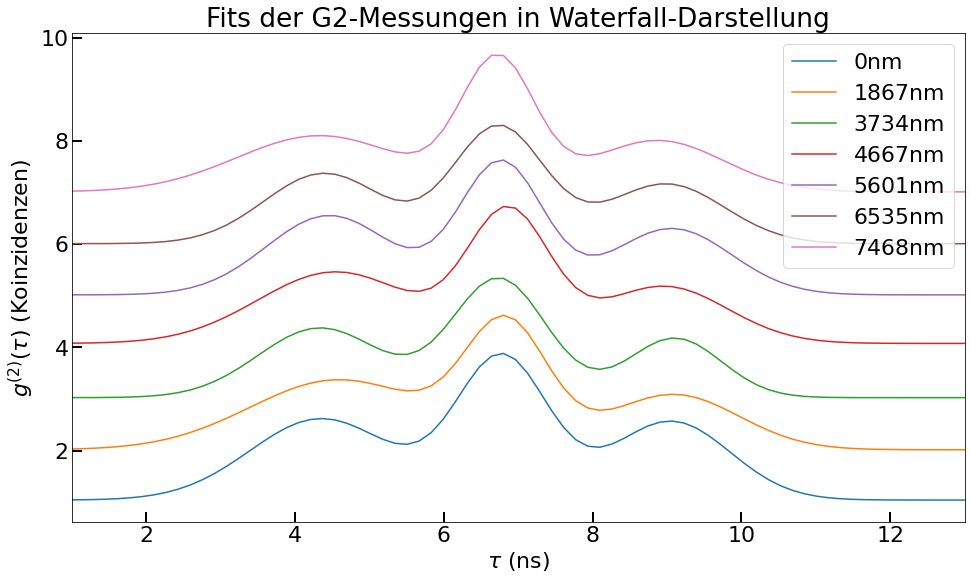

In [111]:
from pathlib import Path

g2_messungen = Path(".")
fit_results = {}
waterfall_plot = plt.subplot()
plot_selection = ["fit_smooth"]
#names = [0, 1867.18, 3734.36, 4667.95, 5601.54, 6535.13, 7468.72]
names = []
for index, file in enumerate(g2_messungen.rglob("Phasendifferenzen/**/*HBTconversion.txt")):
    data = load_data(file)
    df, fit, fit_smooth = fit_combined(data["g2_HBT"], initial_fit=True)
    fit_results[file.parent.name] = df, fit, fit_smooth
    ax = (df + 1*index)[plot_selection].plot(
        title="Fits der G2-Messungen in Waterfall-Darstellung", 
        ax=waterfall_plot, 
        label = file.name
    )
    names.append(PathtoLabel(file))
    print(fit.fit_report())
ax.tick_params(direction ="in", length=10, width=2)
ax.set_xlabel(r'$\tau$ (ns)') 
ax.set_ylabel(r'$g^{(2)}(\tau)$ (Koinzidenzen)')
ax.set_xlim([1.0, 13.0])
ax.legend(names)
plt.savefig("G2_Alle.png")
#print(df.to_latex(index=False)) 

!pip install jupyterlab-autosave-on-focus-change